In [61]:
import torch
import os
import shutil
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from torchvision import transforms
from pathlib import Path
from typing import List, Dict, Any


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model architecture
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes: 0, 90, 180, 270

# Load saved weights
checkpoint = torch.load("checkpoints/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
CROPS_DIR = Path("../data/rotation/classification/test")

In [43]:
(list(CROPS_DIR.iterdir()))

ALL_ANGLES_CROPS = Path("../data/rotation/classification/all_angles_from_test")

os.makedirs("../data/rotation/classification/all_angles_from_test", exist_ok=True)

for p in CROPS_DIR.iterdir():
    print(p)
    
    for f in p.iterdir():
        print(f.name)

        shutil.move(f, ALL_ANGLES_CROPS / f.name)

../data/rotation/classification/test/180
../data/rotation/classification/test/0
../data/rotation/classification/test/90
../data/rotation/classification/test/270


In [47]:
for f in ALL_ANGLES_CROPS.iterdir():
    print(f.name)
    if ("_45.png" in f.name):
        os.remove(f)

10001_32_0_180.png
10001_45_180.png
10001_9_270.png
10001_21_270.png
10001_36_0.png
10001_37_180.png
10001_15_45.png
10001_12_0.png
10000_2_0_270.png
10001_18_0_90.png
10001_18_180.png
10001_18_0_0.png
10001_50_0_90.png
10001_45_0_180.png
10001_18_0_45.png
10001_10_0.png
10001_23_90.png
10001_40_90.png
10001_28_270.png
10001_15_90.png
10001_12_0_90.png
10001_13_0_90.png
10001_19_90.png
10000_7_0_45.png
10001_30_0.png
10001_29_270.png
10001_31_0_90.png
10001_48_0.png
.DS_Store
10001_15_0_180.png
10001_10_0_0.png
10001_14_0.png
10000_4_180.png
10001_17_45.png
10000_4_0_0.png
10001_26_180.png
10001_29_0_270.png
10001_18_0_180.png
10001_26_0_0.png
10001_42_270.png
10001_33_45.png
10001_50_45.png
10001_30_0_45.png
10001_39_0_180.png
10001_31_0_45.png
10001_42_45.png
10001_19_180.png
10001_16_0_270.png
10000_1_0_45.png
10001_11_0.png
10001_49_270.png
10000_7_0_180.png
10001_37_0_90.png
10001_23_0_270.png
10001_46_90.png
10000_3_0_270.png
10001_35_0.png
10001_25_45.png
10001_34_180.png
10001_

In [ ]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match training resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


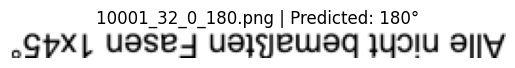

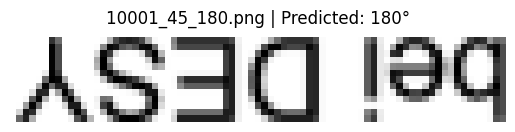

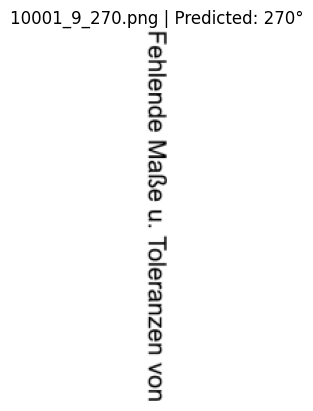

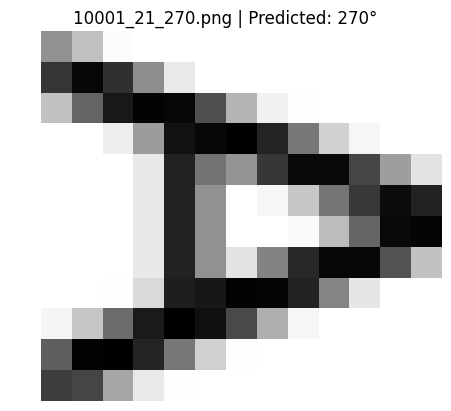

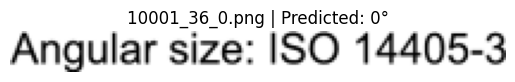

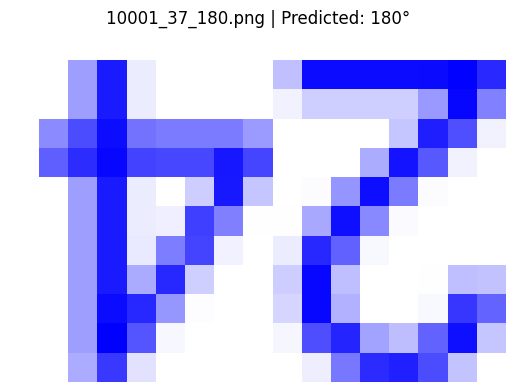

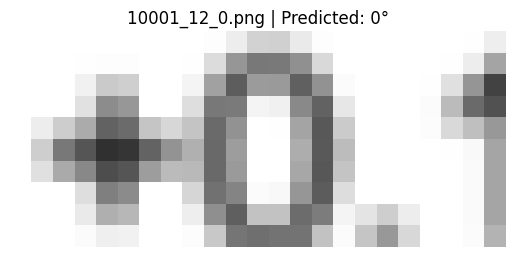

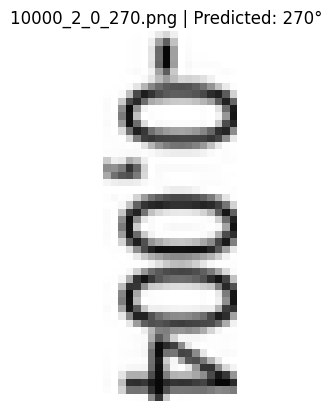

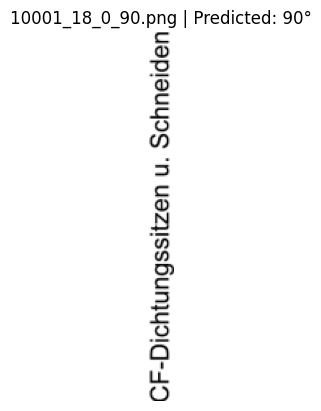

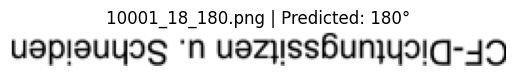

In [67]:
from IPython.display import display
import matplotlib.pyplot as plt

def predict_images():
    CLASS_NAMES = [0, 180, 270, 90]

    count = 0
    for f in ALL_ANGLES_CROPS.iterdir():
        if count >= 10:
            break

        img = Image.open(f).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim

        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)

        pred_angle = CLASS_NAMES[predicted.item()]
        
        # Display the image and prediction
        plt.imshow(img)
        plt.title(f"{f.name} | Predicted: {pred_angle}°")
        plt.axis("off")
        plt.show()

        count += 1

predict_images()